In [1]:
%load_ext autoreload
%autoreload 2

import os

SELECTED_DEVICE = 5
print(f'Setting CUDA visible devices to [{SELECTED_DEVICE}]')
os.environ['CUDA_VISIBLE_DEVICES'] = f'{SELECTED_DEVICE}'
os.environ['JAX_ENABLE_X64'] = 'True'

import jax
import jax.numpy as jnp
import jax.numpy as jnp
import jax.random as jr

import matplotlib.pyplot as plt

Setting CUDA visible devices to [5]


## Distrax

In [3]:
import distrax


from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions

key = jax.random.PRNGKey(1234)
mu = jnp.array([-1., 0., 1.])
sigma = jnp.array([0.1, 0.2, 0.3])

dist_distrax = distrax.MultivariateNormalDiag(mu, sigma)
dist_tfp = tfd.MultivariateNormalDiag(mu, sigma)

samples = dist_distrax.sample(seed=key)

# Both print 1.775
print(dist_distrax.log_prob(samples))
print(dist_tfp.log_prob(samples))

1.260539855282171
1.260539855282171


## JaxKern | Failed

In [4]:
import jaxkern as jk
key = jr.PRNGKey(123)

# Define the points on which we'll evaluate the kernel
X = jr.uniform(key, shape = (10, 1), minval=-3., maxval=3.)
Y = jr.uniform(key, shape = (20, 1), minval=-3., maxval=3.)

# Instantiate the kernel and its parameters
kernel = jk.Matern32()
params = kernel.init_params(key)

# Compute the 10x10 Gram matrix
Kxx = kernel.gram(params, X)

# Compute the 10x20 cross-covariance matrix
Kxy = kernel.cross_covariance(params, X, Y)

# Build a RFF approximation
approx = jk.RFF(kernel, num_basis_fns = 5)
rff_params = approx.init_params(key)

# Build an approximation to the Gram matrix
Qff = approx.gram(rff_params, X)

## GPJax

In [8]:
# Enable Float64 for more stable matrix inversions.
from jax import config
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import (
    Float,
    install_import_hook,
)
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox


config.update("jax_enable_x64", True)


with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx


key = jr.key(42)

# set the default style for plotting

cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

TypeError: 'jaxlib.xla_extension.Device' object is not callable

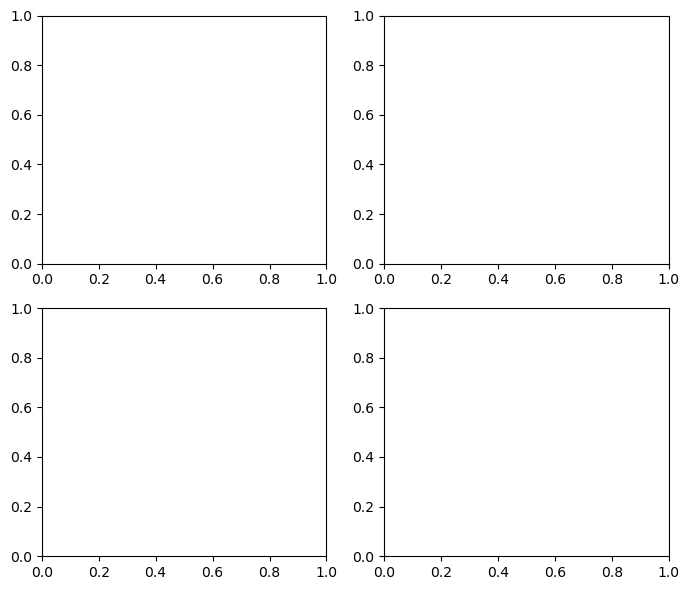

In [9]:
kernels = [
    gpx.kernels.Matern12(),
    gpx.kernels.Matern32(),
    gpx.kernels.Matern52(),
    gpx.kernels.RBF(),
]
fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(7, 6), tight_layout=True)

x = jnp.linspace(-3.0, 3.0, num=200).reshape(-1, 1)

meanf = gpx.mean_functions.Zero()

for k, ax in zip(kernels, axes.ravel()):
    prior = gpx.gps.Prior(mean_function=meanf, kernel=k)
    rv = prior(x)
    y = rv.sample(seed=key, sample_shape=(10,))
    ax.plot(x, y.T, alpha=0.7)
    ax.set_title(k.name)

## Jaxkern vs GPJax

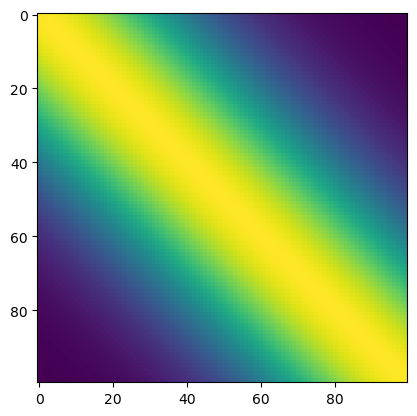

jaxlib.xla_extension.ArrayImpl

In [8]:
lengthscale_ = 0.3
output_scale_ = 5.0
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]

# Jaxkern API:
kernel = jk.RBF()
cov = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x)
plt.imshow(cov)
plt.show()
type(cov)

jaxlib.xla_extension.ArrayImpl

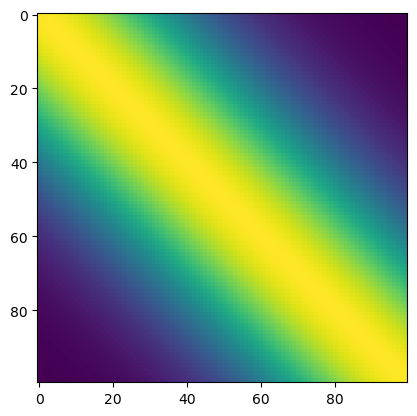

In [9]:
from gpjax import kernels

kernel = kernels.RBF(lengthscale=lengthscale_, variance=output_scale_)
cov = kernel.cross_covariance(x, x)

# or as a single call
cov = kernels.RBF(lengthscale=lengthscale_, variance=output_scale_).cross_covariance(x, x)

plt.imshow(cov)
type(cov)

## Import GPJax as Jaxkern

In [10]:
from gpjax import kernels

lengthscale_ = 0.3
output_scale_ = 5.0
n = 100
x = jnp.linspace(0, 1, n)[:, jnp.newaxis]


from adapter import jaxkern as jk
kernel = jk.RBF()

cov = kernel.cross_covariance(params=dict(lengthscale=lengthscale_,
                                        variance=output_scale_),
                            x=x, y=x) 
type(cov)

init overwriter jaxkern RBF


jaxlib.xla_extension.ArrayImpl